In [1]:
## Import packages
import openeo
import json
from pathlib import Path
import folium
import leafmap.foliumap as leafmap
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from openeo.processes import lte

In [2]:
# Connect to copernicus

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


In [3]:
def read_json(filename: str) -> dict:
    with open(filename, encoding='utf-8') as input:
        field = json.load(input)
        return field

date = ['2023-02-07', '2023-02-07']
aoi = gpd.read_file('glazier.geojson')

In [4]:
center = (float(aoi.centroid.y), float(aoi.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('glazier.geojson', layer_name="glacier")
m

In [5]:
# print(connection.list_collection_ids())

In [6]:
# connection.describe_collection('SENTINEL2_L2A')

In [7]:
bbox = aoi.bounds.iloc[0]
bbox

minx    12.055636
miny    46.996260
maxx    12.429187
maxy    47.196351
Name: 0, dtype: float64

In [8]:
# Get all available bands
all_bands = connection.describe_collection('SENTINEL2_L2A')["summaries"]["eo:bands"]
band_names = [band["name"] for band in all_bands]


collection = 'SENTINEL2_L2A'
spatial_extent = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = date
bands = band_names
properties = {'eo:cloud_cover': lambda x:lte(x, 90)}

In [9]:
s2 = connection.load_collection(collection,
                                spatial_extent = spatial_extent,
                                bands = bands,
                                temporal_extent = temporal_extent,
                                properties = properties)

In [10]:
s2.download('s2.nc')

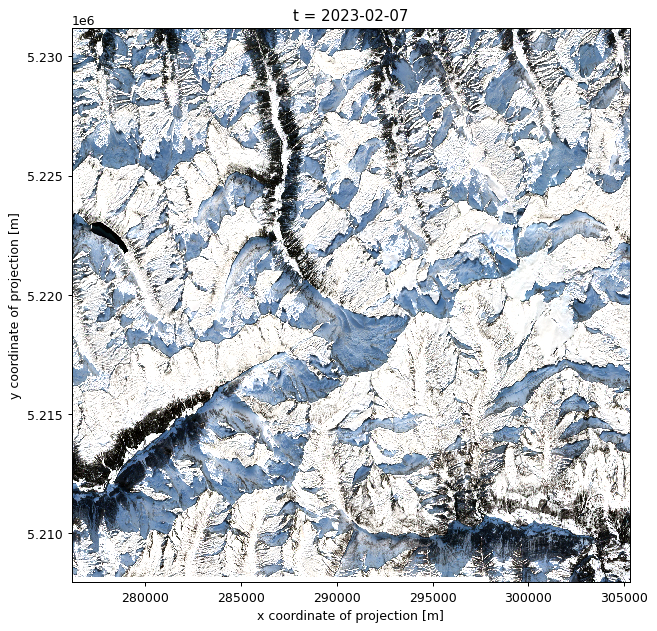

In [11]:
# RGB
import xarray

ds = xarray.load_dataset("s2.nc")
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B04", "B03", "B02"]].to_array(dim="bands")

fig, axes = plt.subplots(figsize=(8, 8), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=10000)

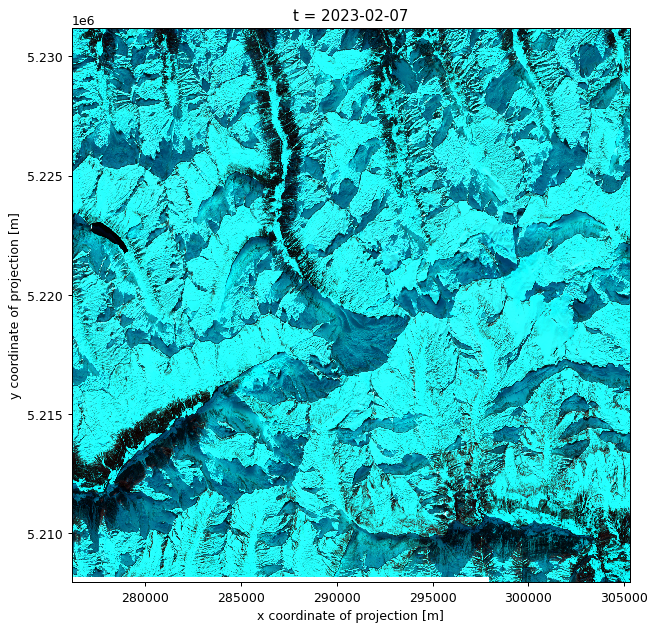

In [12]:
# FCC
# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["B11", "B04", "B03"]].to_array(dim="bands")

fig, axes = plt.subplots(figsize=(8, 8), dpi=90, sharey=True)
data[{"t": 0}].plot.imshow(vmin=0, vmax=10000)

In [13]:
# Creating NDSI
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)

In [14]:
# Creating snowmap
snowmap = ( ndsi > 0.4 ) * 1.0  

In [15]:
# Creating cloud mask
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0

In [16]:
# Applying the cloud mask to the snowmap
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default

In [17]:
# Masking polygon
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(aoi['geometry'][0])

In [18]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2023-02-06', '2023-02-08')
snowmap_cloudfree_1d.download('snowmap.nc')

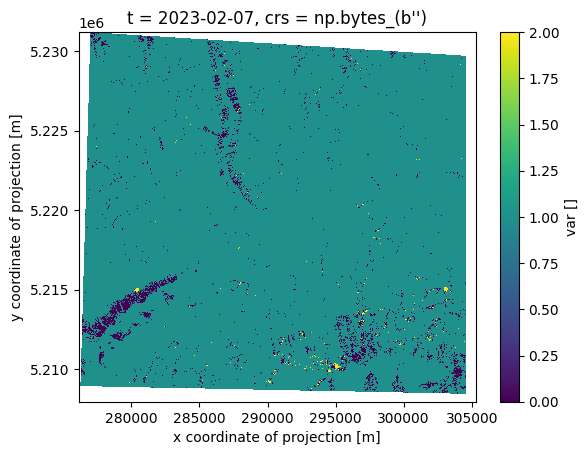

In [19]:
xr.open_dataarray('snowmap.nc',decode_coords="all")[0].plot.imshow()

In [20]:
ds.keys()

KeysView(<xarray.Dataset> Size: 515MB
Dimensions:           (t: 1, x: 2914, y: 2325)
Coordinates:
  * t                 (t) datetime64[ns] 8B 2023-02-07
  * x                 (x) float64 23kB 2.761e+05 2.762e+05 ... 3.053e+05
  * y                 (y) float64 19kB 5.231e+06 5.231e+06 ... 5.208e+06
Data variables: (12/20)
    crs               |S1 1B b''
    B01               (t, y, x) float32 27MB 1.032e+04 1.022e+04 ... 8.558e+03
    B02               (t, y, x) float32 27MB 6.395e+03 7.418e+03 ... 7.569e+03
    B03               (t, y, x) float32 27MB 5.204e+03 7.242e+03 ... 8.665e+03
    B04               (t, y, x) float32 27MB 4.259e+03 6.695e+03 ... 8.45e+03
    B05               (t, y, x) float32 27MB 5.88e+03 7.626e+03 ... 8.247e+03
    ...                ...
    AOT               (t, y, x) float32 27MB 109.0 109.0 109.0 ... 131.0 131.0
    SCL               (t, y, x) float32 27MB 11.0 11.0 11.0 ... 11.0 11.0 11.0
    sunAzimuthAngles  (t, y, x) float32 27MB 162.1 162.1 162.1 ...

In [21]:
# scale dn to reflectance

# List of band names to scale
bands_to_scale = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"]

# Scale the bands
for band in bands_to_scale:
    ds[band] = ds[band] / 10000

# Save the scaled dataset to a new file
ds.to_netcdf("s2_scaled.nc")

In [22]:
s2_scaled = xarray.load_dataset("s2.nc")

In [23]:
# snow albedo
# knap

knap = 0.726 * (s2.band("B03")/10000) - 0.322 * ((s2.band("B03"))/10000)**2 - 0.015 * (s2.band("B08")/10000) + 0.581 * ((s2.band("B08"))/10000)**2

# liang
liang = 0.356 * (s2.band("B02")/10000) + 0.130 * (s2.band("B04")/10000) + 0.373 * (s2.band("B08")/10000) + 0.085 * (s2.band("B11")/10000) + 0.072 * (s2.band("B12")/10000) - 0.0018  


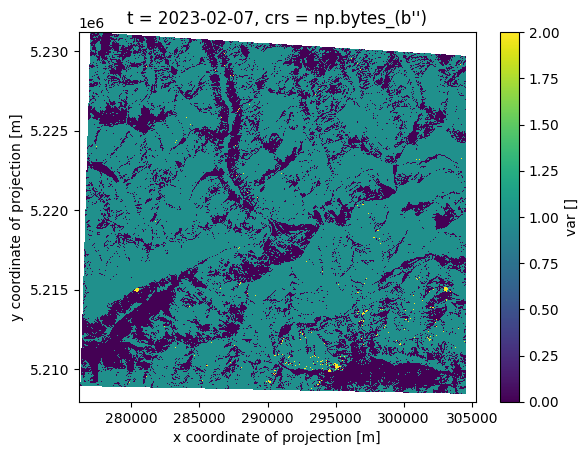

In [24]:
# snowmap knap

snowmap = ( knap > 0.4 ) * 1.0  

# Creating cloud mask
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0

# Applying the cloud mask to the snowmap
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default

# Masking polygon
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(aoi['geometry'][0])

snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2023-02-06', '2023-02-08')
snowmap_cloudfree_1d.download('snowmap_knap.nc')

xr.open_dataarray('snowmap_knap.nc',decode_coords="all")[0].plot.imshow()

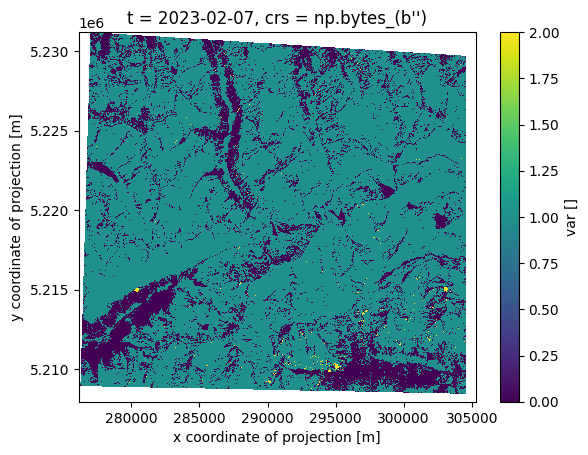

In [25]:
# snowmap liang

snowmap = ( liang > 0.4 ) * 1.0  

# Creating cloud mask
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0

# Applying the cloud mask to the snowmap
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2)

# Masking polygon
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(aoi['geometry'][0])

snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2023-02-06', '2023-02-08')
snowmap_cloudfree_1d.download('snowmap_liang.nc')

xr.open_dataarray('snowmap_liang.nc',decode_coords="all")[0].plot.imshow()

In [26]:
# making a time series for one point
